# Setting

In [10]:
from laboneq.simple import SHFQC
from laboneq.dsl.device import DeviceSetup, create_connection
import numpy as np
from copy import deepcopy
#instantiate ad device setup object
setup = DeviceSetup(uid="test_setup")
#add a dataserver
setup.add_dataserver(host="10.172.11.217", port="8004",uid="test_server")

setup.add_instruments(SHFQC(uid="test_shfqc",server_uid="test_server", address="DEV12576", device_options="SHFQC/PLUS/QC6CH"))

setup.instruments

[SHFQC(
│   uid='test_shfqc',
│   interface='1GbE',
│   connections=[],
│   server_uid='test_server',
│   address='DEV12576',
│   device_options='SHFQC/PLUS/QC6CH',
│   reference_clock_source=None,
│   device_class=0
)
]

In [11]:
#SHFQC(uid="test_shfqc",server_uid="test_server", address="DEV12576", device_options="SHFQC/PLUS/QC6CH").ports

^(1)[https://docs.zhinst.com/labone_q_user_manual/core/functionality_and_concepts/02_logical_signals/concepts/01_signal_types.html]

In [12]:
for ch_idx, q_idx in enumerate([15,16,17,18,19]):# enumerate 안에 len(list) 강제하고싶음
    
    #QA
    setup.add_connections(
        "test_shfqc",
        create_connection(to_signal=f"q{q_idx}/measure", ports="QACHANNELS/0/OUTPUT")) #signal_type="iq"
    setup.add_connections(
        "test_shfqc",
        create_connection(to_signal=f"q{q_idx}/acquire", ports="QACHANNELS/0/INPUT" )) #signal_type="acquire"
    #SG
    setup.add_connections(
        "test_shfqc",
        create_connection(to_signal=f"q{q_idx}/drive", ports=f"SGCHANNELS/{ch_idx}/OUTPUT")) #signal_type="iq" only iq allowed for SG??
    setup.add_connections(
        "test_shfqc",
        create_connection(to_signal=f"q{q_idx}/drive_ef", ports=f"SGCHANNELS/{ch_idx}/OUTPUT")) #signal_type="iq" only iq allowed for SG??
    setup.add_connections(
        "test_shfqc",
        create_connection(to_signal=f"q{q_idx}/cr_drive", ports=f"SGCHANNELS/{ch_idx}/OUTPUT"))#signal_type="iq"


# Savequbit

In [13]:
# from krisszi_core.contrib.jsahn.helper import load_qubit_parameters, save_qubit_parameters
# save_qubit_parameters(qubits={ qubit.uid : qubit for qubit in qubits}, save_folder="./qubit_parameters", filename="sleep")

# Qubits and Quantum Operations

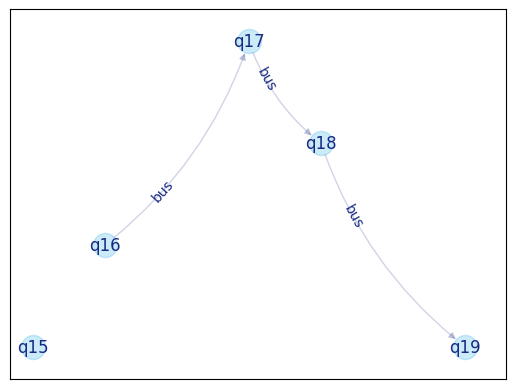

In [ ]:
from laboneq.dsl.quantum.qpu import QPU, QuantumPlatform
from laboneq.dsl.quantum.qpu import QuantumElement

from krisszi_core.contrib.jsahn.operations import TransmonOperations
from krisszi_core.contrib.jsahn.qpu_types.transmon import TransmonQubit, TransmonQubitParameters
from krisszi_core.contrib.jsahn.helper import load_qubit_parameters, save_qubit_parameters

# # #TODO load_qubit_parameters should return list with TransmonQubit, currently it's a dict 
_loaded_qubits = load_qubit_parameters(filename="latest") 
loaded_qubits = list(_loaded_qubits.values())
# save_qubit_parameters(qubits={ qubit.uid : qubit for qubit in qubits}, save_folder="./qubit_parameters")
#qubits = TransmonQubit.from_device_setup(setup) # Also can be done with load_qubit_parameters 
qubits = loaded_qubits

quantum_operations = TransmonOperations()
################################################################################################
qpu = QPU(quantum_elements=qubits, quantum_operations=quantum_operations)
qpu.topology.add_edge("bus", "q16", "q17")
qpu.topology.add_edge("bus", "q17", "q18")
qpu.topology.add_edge("bus", "q18", "q19")
qpu.topology.plot()

# Create a demonstration QuantumPlatform for a transmon QPU:
quantum_platform = QuantumPlatform(setup=setup, qpu=qpu)


from laboneq.simple import workflow
from pathlib import Path

folder_store = workflow.logbook.FolderStore("c:/Users/KRISS/Documents/KAIST/experiment_store")
folder_store.activate()
#folder_store.deactivate()


`TransmonQubit` 의 parameters  외부에서 접근 하는법  
형식은 `TransmonQubitParameters`에서 만들어 놓았고 분류된 parameter 쉽게 확인가능하다. 

- transition_parameters("ge")  
- transition_parameters("ef")  
- readout_parameters()  
- readout_integration_parameters()

parameter 수정은 만든 QuantumElements.parameters. (TransmonQubit.parameters)


from laboneq.simple import Transmon 이거는 **deprecated**
QuantumElements.save 도 **deprecated**

In [5]:
for _, qubit in enumerate(qubits):
    
    
    ##################LOCAL OSCILLATOR FREQUENCY AND CHANNEL POWER ###################################
    qubit.parameters.drive_lo_frequency = 4.8e9
    qubit.parameters.readout_lo_frequency = 7.0e9
    qubit.parameters.readout_range_in =  0
    qubit.parameters.readout_range_out = -25
    qubit.parameters.drive_range = 0 
    
    
    
    ############READOUT PARAMETERS###################################################################
    qubit.parameters.readout_length - 2.0e-6
    qubit.parameters.readout_pulse['function'] = 'GaussianSquare'
    qubit.parameters.readout_pulse['sigma'] = 0.1
    qubit.parameters.readout_pulse['width'] = None
    qubit.parameters.readout_pulse['risefall_sigma_ratio'] = 3.0
    qubit.parameters.readout_amplitude = 1.0  #WARNING! 이거 SWEEP 할때 오버라이딩이 안되고 여기서 SCALING 됨
    
    
    ###########SPECTROSCOPY PARAMETERS###############################################################
    # Pulsed qubit spectroscopy drive ,  
    qubit.parameters.spectroscopy_pulse['function'] = 'GaussianSquare'
    qubit.parameters.spectroscopy_length = 5.0e-6
    qubit.parameters.spectroscopy_pulse['sigma'] = 0.2
    qubit.parameters.spectroscopy_pulse['width'] = None
    qubit.parameters.spectroscopy_pulse['risefall_sigma_ratio'] = 3.0
    qubit.parameters.spectroscopy_amplitude=0.01 
    
    
    ###########TRANSITION PARAMETERS#####################################
    qubit.parameters.ge_drive_amplitude_pi = 1.0
    qubit.parameters.ge_drive_amplitude_pi2 = 0.5
    qubit.parameters.ef_drive_amplitude_pi = 1.0
    qubit.parameters.ef_drive_amplitude_pi2 = 0.5 # Initialization just to avoid potential scaling problem
    

qubits[3].parameters.readout_amplitude = 0.5
qubits[4].parameters.readout_amplitude = 0.5
qubits[2].parameters.readout_amplitude = 0.5


NameError: name 'qubits' is not defined

In [ ]:
# from laboneq.simple import *
# measure_line, ro_params =  qubits[3].readout_parameters()
# print(measure_line)
# print(ro_params)
# ro_pulse = dsl.create_pulse(ro_params["pulse"])

(`Calibratable` , `CalibrationItem`)  



#### Baseline cal : Calibrate from `DeviceSetup`

(`LogicalSignal`, `SignalCalibration`)  


#### Calibrate from `Experiment`

(`ExperimentSignal`, `SignalCalibration`)
Overriding is possible  

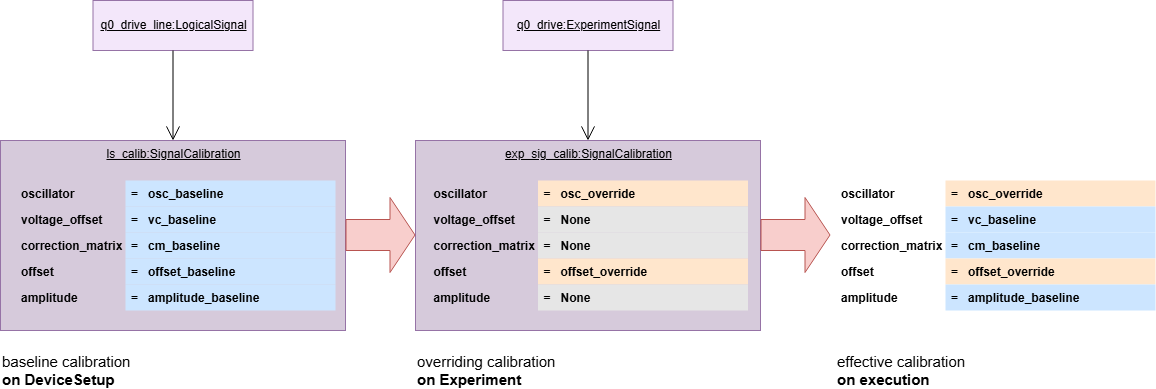


In [ ]:
#setup

In [ ]:
#quantum_platform.qpu.quantum_elements[0]

In [ ]:
 # Hooray I just imported ramsey workflow! 
#ramsey.experiment_workflow.src 

from laboneq.simple import Session
session = Session(setup)
session.connect()


`Workflow` object is a collection of connected `Tasks` or other `Workflows` whoes inputs and outputs depend on each other.  
The parent `Workflow` automatically distributes **options**(`WorkflowOptions`) to all its `Tasks`

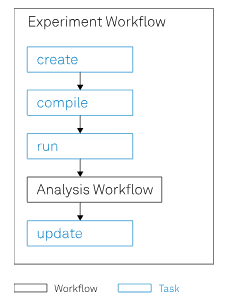

# 1 spectroscopy

## 1.2 Resonator Spectroscopy Amplitude

In [ ]:
from laboneq_applications.experiments import resonator_spectroscopy_amplitude 
from laboneq_applications.experiments.options import ResonatorSpectroscopyExperimentOptions
options = resonator_spectroscopy_amplitude.experiment_workflow.options()
options.update(False)  # updates the qubit parameter "readout_resonator_frequency"
options.use_cw(False)
# The resonator spectroscopy can only be done on one qubit at a time
qubit_to_measure = qubits[2]
q= qubit_to_measure
temporary_parameters = {}

temp_pars = deepcopy(q.parameters)
temp_pars.readout_amplitude = 1.0
temporary_parameters[q.uid] = temp_pars

print(q.readout_parameters())
print(q.parameters.readout_range_out)
frequencies = q.parameters.readout_resonator_frequency + np.linspace(-2e6, 2e6, 51)
amplitudes = np.linspace(0.0,1.0,101)

exp_workflow = resonator_spectroscopy_amplitude.experiment_workflow(
    session=session,
    qpu=qpu,
    qubit=qubit_to_measure,
    frequencies=frequencies,
    amplitudes=amplitudes,
    options=options,
    temporary_parameters=temporary_parameters
)
workflow_result = exp_workflow.run()

## 1.1 Resonator Spectroscopy

- Qubit/Resonator Spectroscopy Workflow uses `AcquisitionType.SPECTROSCOPY`   
Note that actual frequency of a hardware oscillator is being sweeped  
- CW spectroscopy / Pulsed spectroscopy can be specified from options

In [ ]:
qubits[3].readout_parameters()

In [ ]:
from laboneq_applications.experiments import resonator_spectroscopy
#from laboneq_applications.experiments.options import ResonatorSpectroscopyExperimentOptions


qubits[3].readout_parameters()
qubits[3].parameters.readout_range_out

In [ ]:
from laboneq_applications.experiments import resonator_spectroscopy
options = resonator_spectroscopy.experiment_workflow.options()
options.update(True)  # updates the qubit parameter "readout_resonator_frequency"
options.count(4096)
options.use_cw(False)

# The resonator spectroscopy can only be done on one qubit at a time
qubit_to_measure = qubits[2]
q= qubit_to_measure
temporary_parameters = {}

temp_pars = deepcopy(q.parameters)
temporary_parameters[q.uid] = temp_pars
print(q.readout_parameters())
frequencies = q.parameters.readout_resonator_frequency + np.linspace(-10e6, 10e6, 501) #qubit_to_measure.parameters.readout_resonator_frequency 
exp_workflow = resonator_spectroscopy.experiment_workflow(
    session=session,
    qpu=qpu,
    qubit=qubit_to_measure,
    frequencies=frequencies,
    temporary_parameters=temporary_parameters,
    options=options
)
workflow_result = exp_workflow.run()

In [ ]:
workflow_result.output

## 1.4 Qubit Spectroscopy Amplitude

Uses spectroscopy pulses as a drive

In [ ]:
qubits[3]

In [ ]:
from laboneq_applications.experiments import qubit_spectroscopy_amplitude 
options = qubit_spectroscopy_amplitude.experiment_workflow.options()
options.count(4096)
options.update(False)  # updates the qubit parameter "resonance_frequency_ge"
options.use_cw = False

 
qubits_to_measure = [qubits[2]] #multiple qubits ->  parallel

temporary_parameters = {}
for q in qubits_to_measure:
    temp_pars = deepcopy(q.parameters)
    temporary_parameters[q.uid] = temp_pars
    print(q.parameters.resonance_frequency_ge)
frequencies = [
    q.parameters.resonance_frequency_ge + np.linspace(-2e6, 2e6, 51) 
    for q in qubits_to_measure
] #

amplitudes = [
np.linspace(0,0.5,51)
] #
exp_workflow = qubit_spectroscopy_amplitude.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=qubits_to_measure,
    temporary_parameters=temporary_parameters,
    frequencies=frequencies,
    amplitudes=amplitudes,
    options=options
)
workflow_result = exp_workflow.run()

## 1.3 Qubit Spectroscopy

.spectroscopy_drive

In [ ]:
qubits[2].parameters.drive_range = 0

In [ ]:
qubits[2].parameters.spectroscopy_amplitude =0.01

In [ ]:
from laboneq_applications.experiments import qubit_spectroscopy 
import numpy as np
from copy import deepcopy
options = qubit_spectroscopy.experiment_workflow.options()
options.count(4096)
options.update(True)  # updates the qubit parameter "resonance_frequency_ge"


qubits_to_measure = [qubits[4]]

temporary_parameters = {}
for q in qubits_to_measure:
    temp_pars = deepcopy(q.parameters)
    temporary_parameters[q.uid] = temp_pars
    print(q.parameters.resonance_frequency_ge)
    print(q.spectroscopy_parameters())
frequencies = [
    q.parameters.resonance_frequency_ge + np.linspace(-20e6, 20e6, 501)  # q.parameters.resonance_frequency_ge
    for q in qubits_to_measure
] #
exp_workflow = qubit_spectroscopy.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=qubits_to_measure[0],
    temporary_parameters=temporary_parameters,
    frequencies=frequencies[0],
    options=options
)
workflow_result = exp_workflow.run()

In [ ]:
workflow_result.tasks

In [ ]:
#save_qubit_parameters(qubits={ qubit.uid : qubit for qubit in qubits}, save_folder="./qubit_parameters", filename="1st")

# 2. Rabi Amplitude

Uses predefined x180 from quantum operations


options acqusition type innitially 

In [ ]:
qubits[2].transition_parameters()

In [ ]:
from laboneq_applications.experiments import amplitude_rabi
from laboneq.simple import AcquisitionType

options = amplitude_rabi.experiment_workflow.options()
options.update(True)
options.active_reset(False)
options.acquisition_type(AcquisitionType.INTEGRATION) 
#options.count

transition_to_calibrate = "ge"
options.transition(transition_to_calibrate)
options.cal_states(transition_to_calibrate)

qubits_to_measure = [qubits[2]]

exp_workflow = amplitude_rabi.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=qubits_to_measure,
    amplitudes=[np.linspace(0, 1.0, 21) for q in qubits_to_measure],
    options=options
)
workflow_result = exp_workflow.run()


# 3. Ramsey

In [ ]:
from laboneq_applications.experiments import ramsey,
options = ramsey.experiment_workflow.options()
# updates the qubit parameters "resonance_frequency_ge" and ge_T2_star
options.update(True)

transition_to_calibrate = "ge"
options.transition(transition_to_calibrate)
options.cal_states(transition_to_calibrate)

# Note: if neighbouring qubits are physically coupled by a resonator,
# you usually don't want to run Ramsey in parallel on them because
# your result will be skewed by strong residual-ZZ coupling.
# Next-nearest neighbours is typically okay.
qubits_to_measure = [qubits[2]]

delays = [
    np.linspace(0, 1e-6, 101)
    if transition_to_calibrate == "ef"
    else np.linspace(0, 20e-6, 101)
    for q in qubits_to_measure
]
detunings = [
    11.76e6 if transition_to_calibrate == "ef"
    else 0.2e6 for q in qubits_to_measure]

exp_workflow = ramsey.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=qubits_to_measure,
    delays=delays,
    detunings=detunings,
    options=options
)

workflow_result = exp_workflow.run()

# 4. DRAG CAL
여기까지하고ㅓ

In [1]:
from laboneq_applications.experiments import drag_q_scaling
options = drag_q_scaling.experiment_workflow.options()
options.update(True)


drag = drag_q_scaling.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=[qubits[2]],
    q_scalings=[np.linspace(-0.01,0.02,51)],
    options=options
)

drag_result = drag.run()

NameError: name 'session' is not defined

In [ ]:
drag.graph.tree

In [ ]:
qubits[2].parameters.ge_drive_pulse

In [ ]:
from laboneq_applications.tasks.parameter_updating import update_qubits
#Manually Updating the Qubit Parameters
update_qubits(qpu=qpu, qubit_parameters=drag_result.tasks["analysis_workflow"].output['new_parameter_values'])

# Error Amplification

In [ ]:
session

In [ ]:
from laboneq_applications.experiments import amplitude_fine

options = amplitude_fine.experiment_workflow_x180.options()
options.update(False)
options.acquisition_type()

error_amp = amplitude_fine.experiment_workflow_x180(
    session=session,
    qpu=qpu,
    qubits=[qubits[2]],
    repetitions=[[1,2,3,4]],
    options=options
)

error_amp_result = error_amp.run()


# IQ Blobs
TuneupExperimentOption 상속

In [ ]:
from laboneq_applications.experiments import iq_blobs
options = iq_blobs.experiment_workflow.options()
#options.update(False)
options.transition = "ge"
options.count(4096)
#options.use_cal_traces = True


qubits_to_measure = [qubits[2]]


exp_workflow = iq_blobs.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=qubits_to_measure,
    states ="ge",
    options=options,
)

workflow_result = exp_workflow.run()

In [ ]:
qubits[2].parameters.readout_resonator_frequency

In [ ]:
from laboneq_applications.experiments import dispersive_shift

options = dispersive_shift.experiment_workflow.options()
options.update(False)

#options.use_cal_traces = True

q = qubits[2]


dispersive = dispersive_shift.experiment_workflow(
    session=session,
    qpu=qpu,
    qubit=q,
    frequencies= q.parameters.readout_resonator_frequency +np.linspace(-5e6, +5e6, 101), 
    states ="ge",
    options=options,
)

dispersive_result = dispersive.run()

# 5. T1

# 6. Echo

In [ ]:
from laboneq_applications.experiments import time_traces